### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [19]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [20]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 126 elements
My custom valing-dataset has 42 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

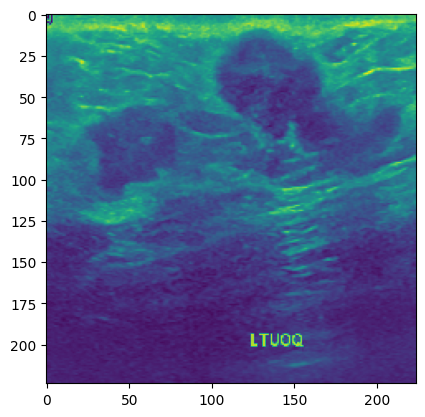

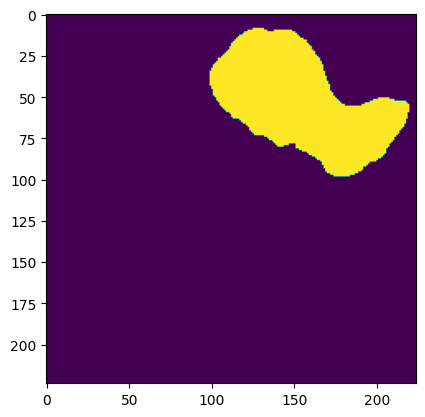

3픽셀의 평균값이라 색깔이 변경됨.


In [21]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
# Begin training
from models.pop_medical_seg_models.unet import UNet

model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [23]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [24]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'Unet'
data_name = 'malignant'

# 5. Training

 Epoch: 1 of 100, Iter.: 16 of 16, Train Loss: 1.318617, IoU: 0.176595, Dice: 0.279417
 Epoch: 1 of 100, Iter.: 16 of 16, Valid Loss: 1.420611, IoU: 0.000000, Dice: 0.000000

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


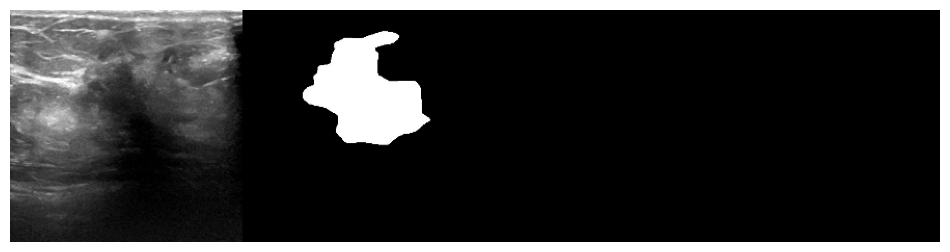

 Epoch: 2 of 100, Iter.: 16 of 16, Train Loss: 1.119959, IoU: 0.380220, Dice: 0.520247
 Epoch: 2 of 100, Iter.: 16 of 16, Valid Loss: 1.524748, IoU: 0.185647, Dice: 0.287296


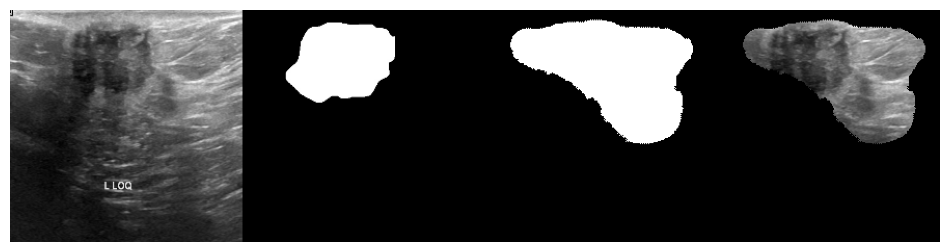

 Epoch: 3 of 100, Iter.: 16 of 16, Train Loss: 0.994823, IoU: 0.436699, Dice: 0.572039
 Epoch: 3 of 100, Iter.: 16 of 16, Valid Loss: 1.110965, IoU: 0.402253, Dice: 0.536422


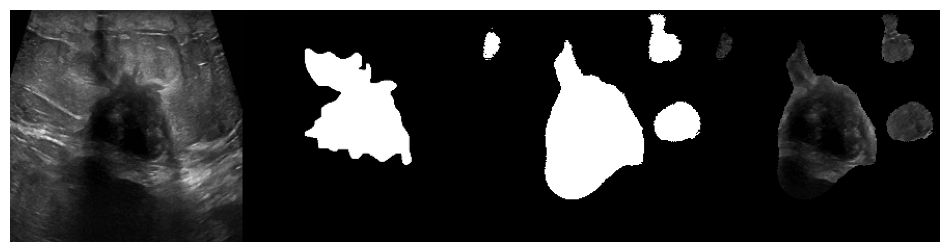

 Epoch: 4 of 100, Iter.: 16 of 16, Train Loss: 0.947124, IoU: 0.465896, Dice: 0.600384
 Epoch: 4 of 100, Iter.: 16 of 16, Valid Loss: 1.139707, IoU: 0.411147, Dice: 0.549626


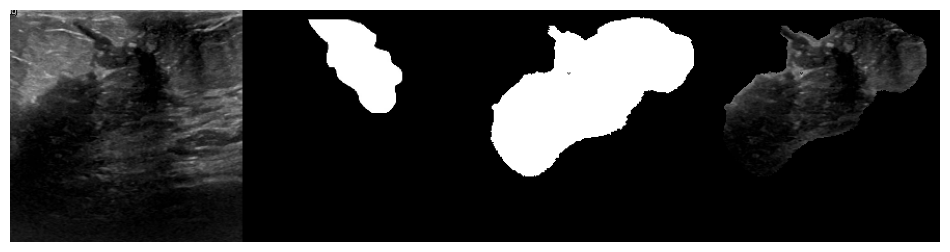

 Epoch: 5 of 100, Iter.: 16 of 16, Train Loss: 0.888244, IoU: 0.489090, Dice: 0.619072
 Epoch: 5 of 100, Iter.: 16 of 16, Valid Loss: 0.925197, IoU: 0.438234, Dice: 0.576229


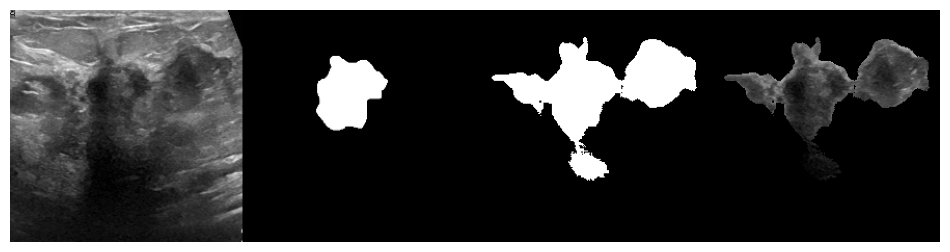

 Epoch: 6 of 100, Iter.: 16 of 16, Train Loss: 0.877608, IoU: 0.490592, Dice: 0.623494
 Epoch: 6 of 100, Iter.: 16 of 16, Valid Loss: 0.859308, IoU: 0.489483, Dice: 0.619151


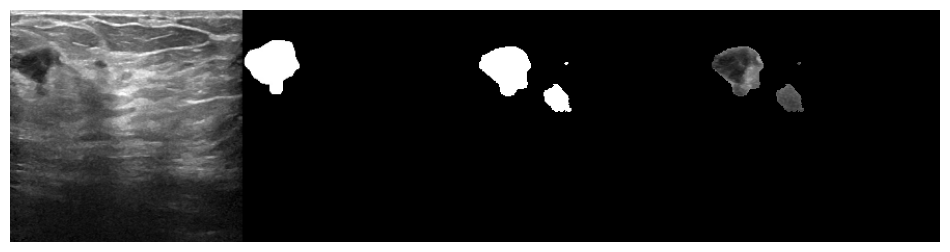

 Epoch: 7 of 100, Iter.: 16 of 16, Train Loss: 0.862158, IoU: 0.506855, Dice: 0.636595
 Epoch: 7 of 100, Iter.: 16 of 16, Valid Loss: 0.891327, IoU: 0.479758, Dice: 0.611266


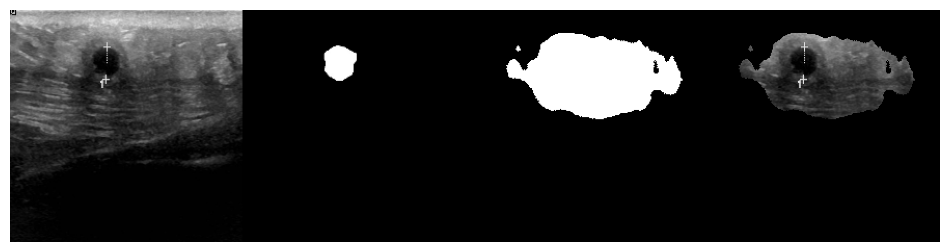

 Epoch: 8 of 100, Iter.: 16 of 16, Train Loss: 0.809573, IoU: 0.556518, Dice: 0.685886
 Epoch: 8 of 100, Iter.: 16 of 16, Valid Loss: 0.911315, IoU: 0.394115, Dice: 0.498418


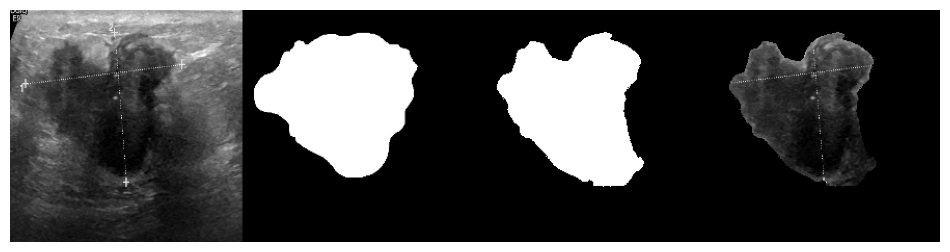

 Epoch: 9 of 100, Iter.: 16 of 16, Train Loss: 0.796860, IoU: 0.548708, Dice: 0.678145
 Epoch: 9 of 100, Iter.: 16 of 16, Valid Loss: 0.823585, IoU: 0.485509, Dice: 0.611522


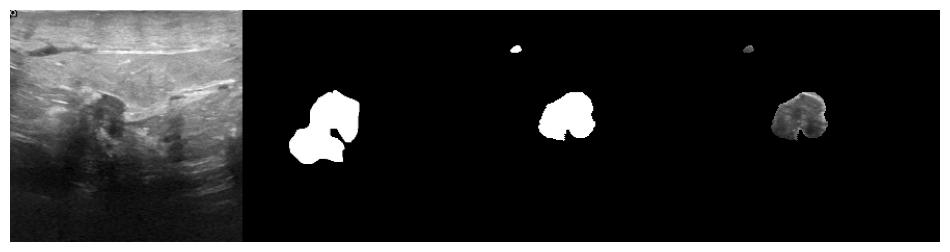

 Epoch: 10 of 100, Iter.: 16 of 16, Train Loss: 0.749051, IoU: 0.584459, Dice: 0.708338
 Epoch: 10 of 100, Iter.: 16 of 16, Valid Loss: 0.880542, IoU: 0.498471, Dice: 0.631920


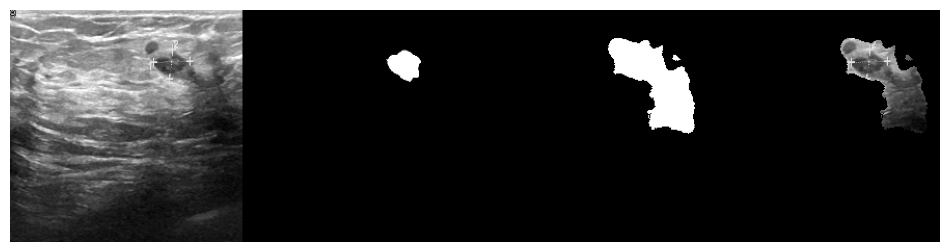

 Epoch: 11 of 100, Iter.: 16 of 16, Train Loss: 0.735888, IoU: 0.609574, Dice: 0.727272
 Epoch: 11 of 100, Iter.: 16 of 16, Valid Loss: 0.861639, IoU: 0.406492, Dice: 0.523416


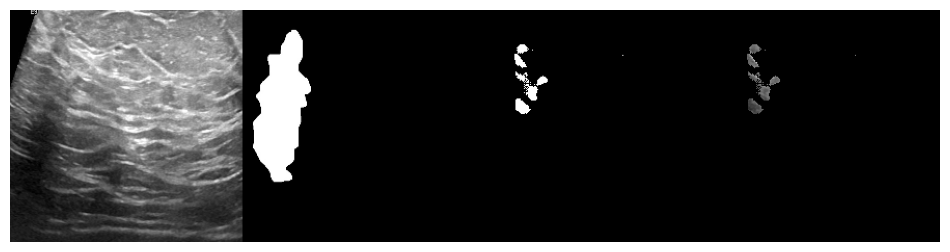

 Epoch: 12 of 100, Iter.: 16 of 16, Train Loss: 0.703679, IoU: 0.596959, Dice: 0.713293
 Epoch: 12 of 100, Iter.: 16 of 16, Valid Loss: 1.044809, IoU: 0.401274, Dice: 0.541527


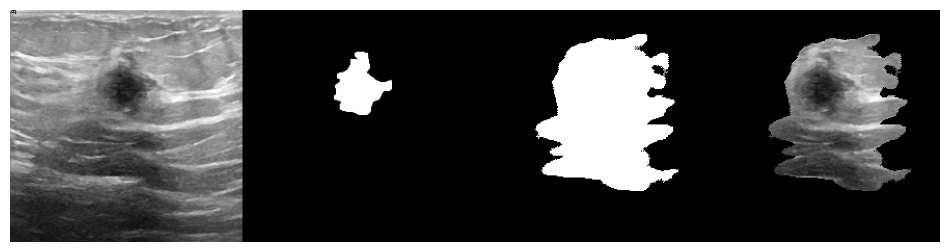

 Epoch: 13 of 100, Iter.: 16 of 16, Train Loss: 0.688343, IoU: 0.604522, Dice: 0.726970
 Epoch: 13 of 100, Iter.: 16 of 16, Valid Loss: 0.866160, IoU: 0.453681, Dice: 0.582519


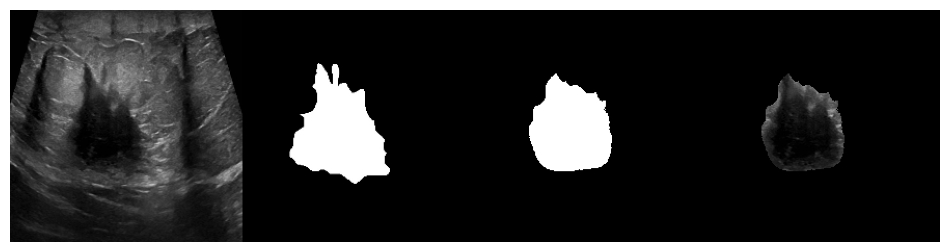

 Epoch: 14 of 100, Iter.: 16 of 16, Train Loss: 0.672674, IoU: 0.630349, Dice: 0.746425
 Epoch: 14 of 100, Iter.: 16 of 16, Valid Loss: 0.803581, IoU: 0.489946, Dice: 0.608485


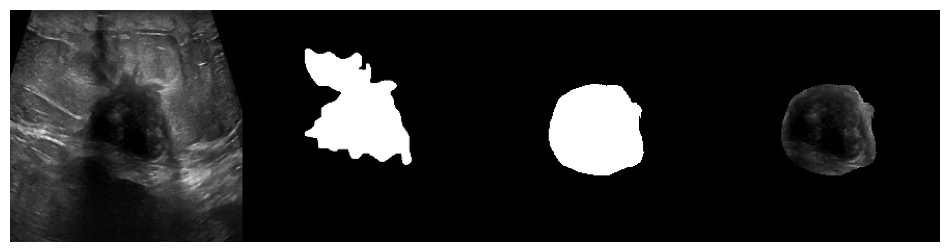

 Epoch: 15 of 100, Iter.: 16 of 16, Train Loss: 0.652115, IoU: 0.631224, Dice: 0.749781
 Epoch: 15 of 100, Iter.: 16 of 16, Valid Loss: 0.789731, IoU: 0.468879, Dice: 0.594116


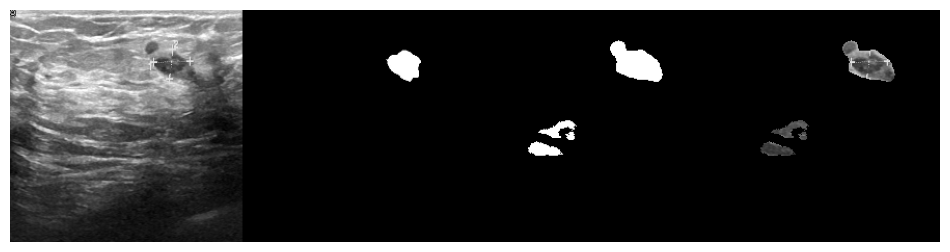

 Epoch: 16 of 100, Iter.: 16 of 16, Train Loss: 0.639731, IoU: 0.636879, Dice: 0.754891
 Epoch: 16 of 100, Iter.: 16 of 16, Valid Loss: 0.930755, IoU: 0.352533, Dice: 0.443852


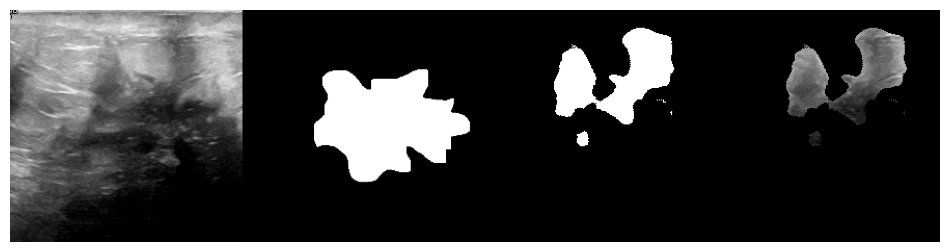

 Epoch: 17 of 100, Iter.: 16 of 16, Train Loss: 0.647005, IoU: 0.622258, Dice: 0.740580
 Epoch: 17 of 100, Iter.: 16 of 16, Valid Loss: 1.010934, IoU: 0.367445, Dice: 0.506588


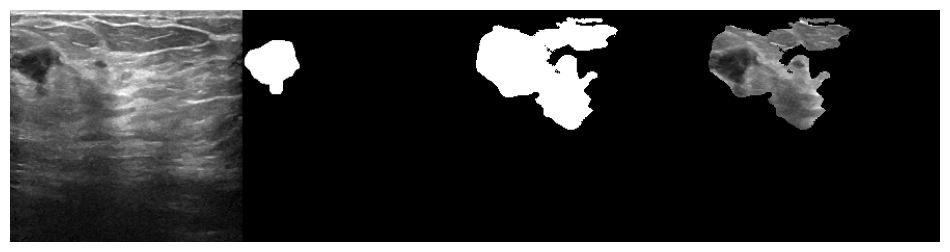

 Epoch: 18 of 100, Iter.: 16 of 16, Train Loss: 0.623248, IoU: 0.635729, Dice: 0.756462
 Epoch: 18 of 100, Iter.: 16 of 16, Valid Loss: 0.759939, IoU: 0.502173, Dice: 0.631596


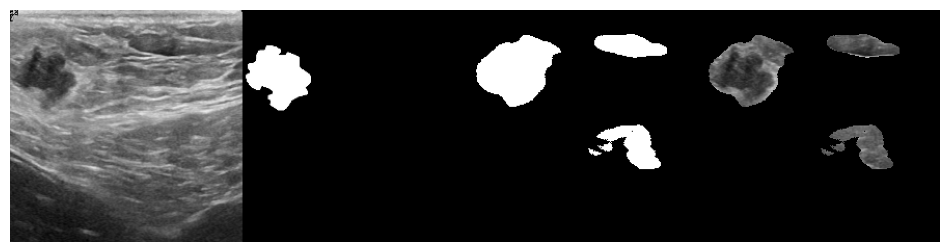

 Epoch: 19 of 100, Iter.: 16 of 16, Train Loss: 0.581822, IoU: 0.672767, Dice: 0.783494
 Epoch: 19 of 100, Iter.: 16 of 16, Valid Loss: 0.832553, IoU: 0.459906, Dice: 0.578776


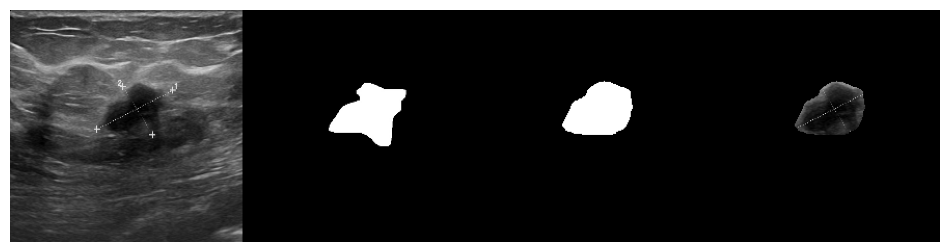

 Epoch: 20 of 100, Iter.: 16 of 16, Train Loss: 0.572827, IoU: 0.684099, Dice: 0.794277
 Epoch: 20 of 100, Iter.: 16 of 16, Valid Loss: 0.762879, IoU: 0.480550, Dice: 0.602137


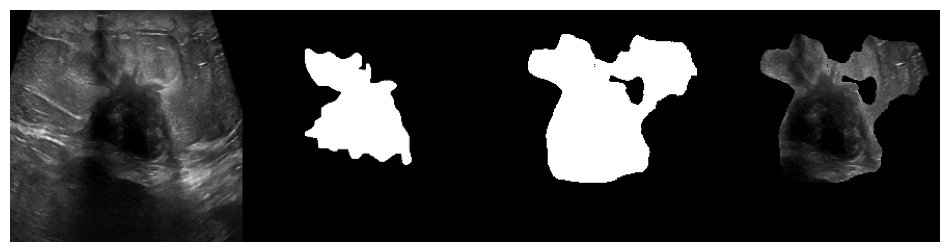

 Epoch: 21 of 100, Iter.: 16 of 16, Train Loss: 0.529078, IoU: 0.711603, Dice: 0.818659
 Epoch: 21 of 100, Iter.: 16 of 16, Valid Loss: 0.774240, IoU: 0.506575, Dice: 0.619727


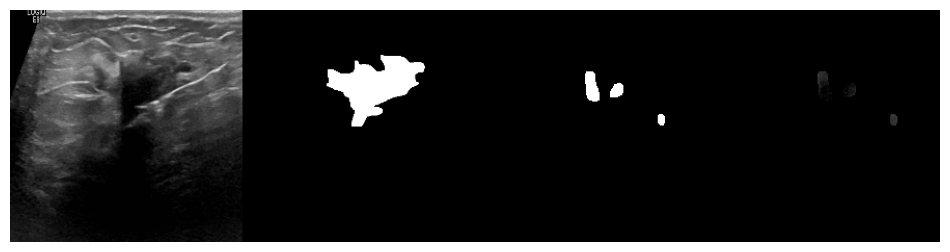

 Epoch: 22 of 100, Iter.: 16 of 16, Train Loss: 0.501095, IoU: 0.742618, Dice: 0.842402
 Epoch: 22 of 100, Iter.: 16 of 16, Valid Loss: 0.664016, IoU: 0.583040, Dice: 0.694475


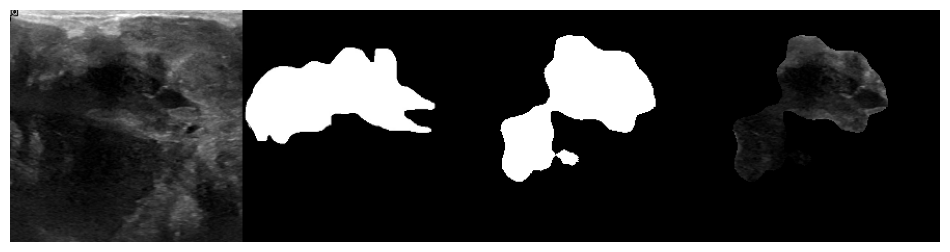

 Epoch: 23 of 100, Iter.: 16 of 16, Train Loss: 0.510998, IoU: 0.721874, Dice: 0.822110
 Epoch: 23 of 100, Iter.: 16 of 16, Valid Loss: 0.717681, IoU: 0.518278, Dice: 0.639135


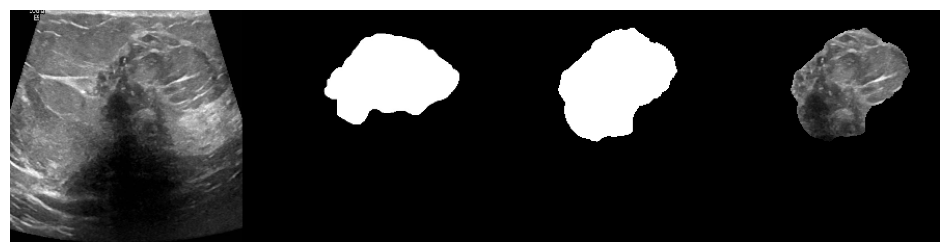

 Epoch: 24 of 100, Iter.: 16 of 16, Train Loss: 0.516466, IoU: 0.701673, Dice: 0.809060
 Epoch: 24 of 100, Iter.: 16 of 16, Valid Loss: 0.732132, IoU: 0.515175, Dice: 0.633962


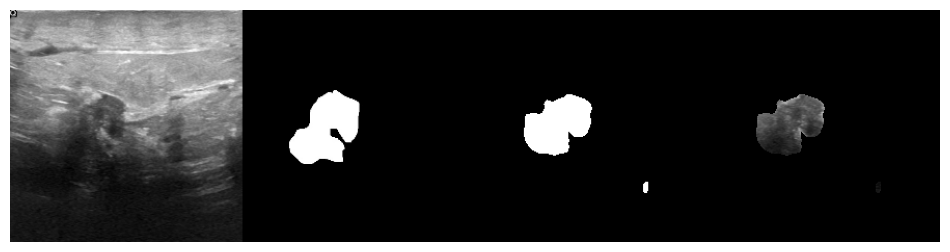

 Epoch: 25 of 100, Iter.: 16 of 16, Train Loss: 0.464029, IoU: 0.754402, Dice: 0.851988
 Epoch: 25 of 100, Iter.: 16 of 16, Valid Loss: 0.689562, IoU: 0.522729, Dice: 0.649834


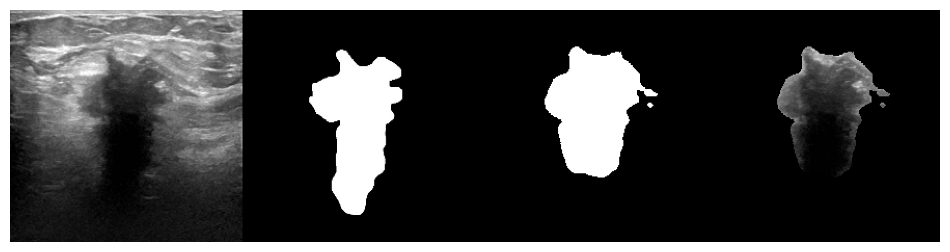

 Epoch: 26 of 100, Iter.: 16 of 16, Train Loss: 0.471573, IoU: 0.736052, Dice: 0.836388
 Epoch: 26 of 100, Iter.: 16 of 16, Valid Loss: 0.753520, IoU: 0.487016, Dice: 0.612821


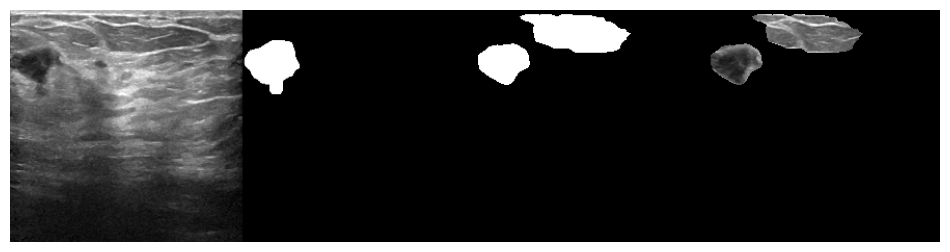

 Epoch: 27 of 100, Iter.: 16 of 16, Train Loss: 0.464930, IoU: 0.733613, Dice: 0.831893
 Epoch: 27 of 100, Iter.: 16 of 16, Valid Loss: 0.830983, IoU: 0.403053, Dice: 0.505073


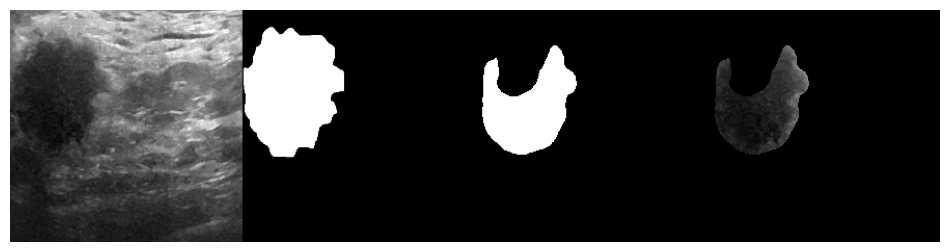

 Epoch: 28 of 100, Iter.: 16 of 16, Train Loss: 0.439701, IoU: 0.753322, Dice: 0.849157
 Epoch: 28 of 100, Iter.: 16 of 16, Valid Loss: 0.700322, IoU: 0.510253, Dice: 0.626443


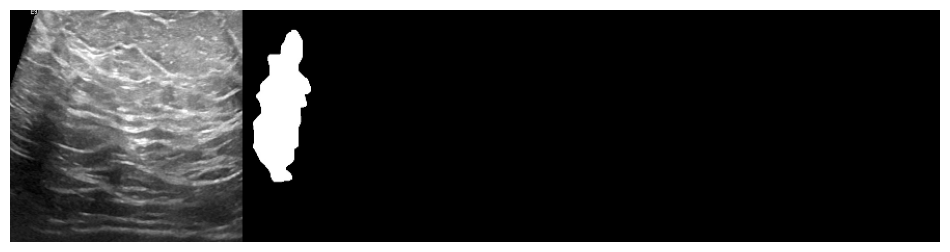

 Epoch: 29 of 100, Iter.: 16 of 16, Train Loss: 0.421940, IoU: 0.771727, Dice: 0.862836
 Epoch: 29 of 100, Iter.: 16 of 16, Valid Loss: 0.728430, IoU: 0.481190, Dice: 0.596349


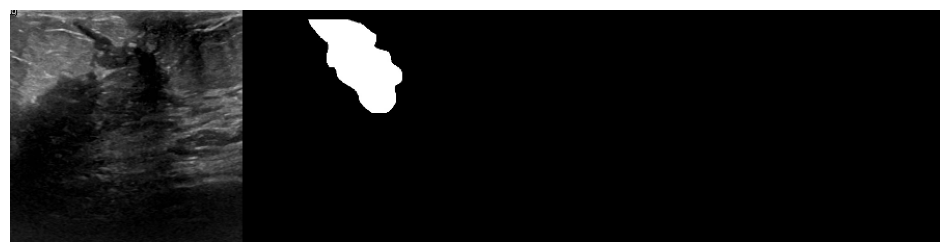

 Epoch: 30 of 100, Iter.: 16 of 16, Train Loss: 0.403323, IoU: 0.780016, Dice: 0.868899
 Epoch: 30 of 100, Iter.: 16 of 16, Valid Loss: 0.655549, IoU: 0.555415, Dice: 0.676219


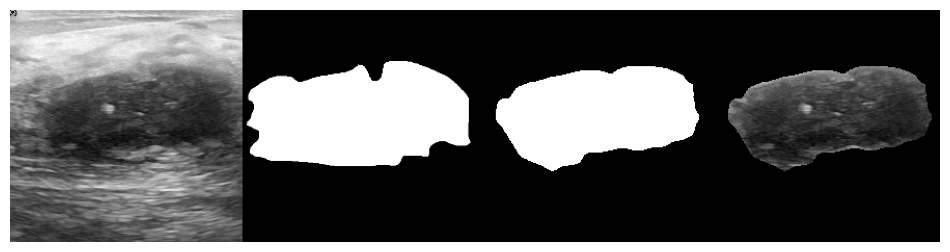

 Epoch: 31 of 100, Iter.: 16 of 16, Train Loss: 0.379377, IoU: 0.796336, Dice: 0.881396
 Epoch: 31 of 100, Iter.: 16 of 16, Valid Loss: 0.639576, IoU: 0.566440, Dice: 0.680090


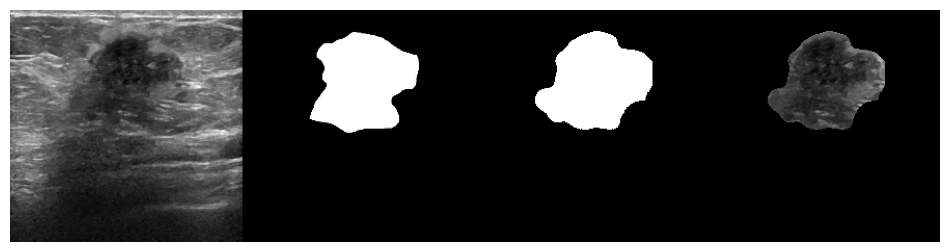

 Epoch: 32 of 100, Iter.: 16 of 16, Train Loss: 0.367844, IoU: 0.813762, Dice: 0.894560
 Epoch: 32 of 100, Iter.: 16 of 16, Valid Loss: 0.616639, IoU: 0.555317, Dice: 0.671850


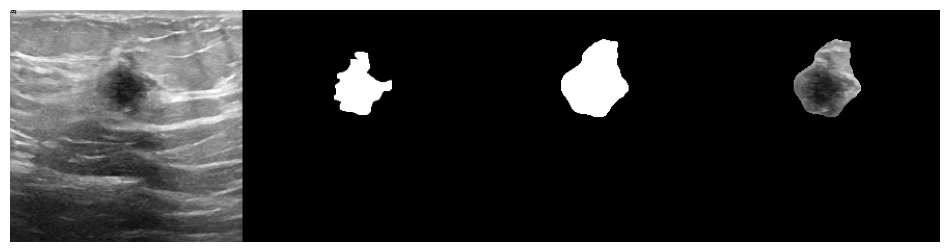

 Epoch: 33 of 100, Iter.: 16 of 16, Train Loss: 0.350910, IoU: 0.819728, Dice: 0.897828
 Epoch: 33 of 100, Iter.: 16 of 16, Valid Loss: 0.639320, IoU: 0.544775, Dice: 0.669064


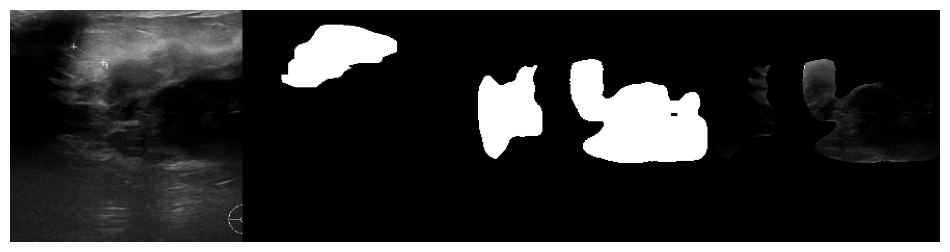

 Epoch: 34 of 100, Iter.: 16 of 16, Train Loss: 0.335253, IoU: 0.836034, Dice: 0.906754
 Epoch: 34 of 100, Iter.: 16 of 16, Valid Loss: 0.745680, IoU: 0.458466, Dice: 0.566767


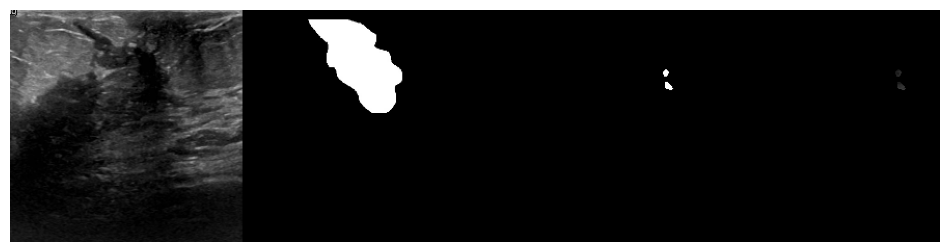

 Epoch: 35 of 100, Iter.: 16 of 16, Train Loss: 0.340269, IoU: 0.818887, Dice: 0.894249
 Epoch: 35 of 100, Iter.: 16 of 16, Valid Loss: 0.630541, IoU: 0.546297, Dice: 0.665046


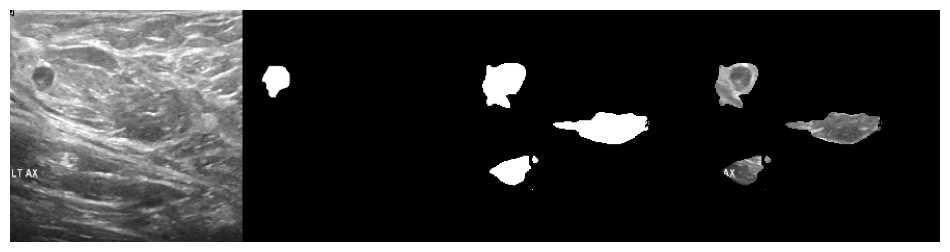

 Epoch: 36 of 100, Iter.: 16 of 16, Train Loss: 0.321919, IoU: 0.842717, Dice: 0.913076
 Epoch: 36 of 100, Iter.: 16 of 16, Valid Loss: 0.592109, IoU: 0.571066, Dice: 0.688750


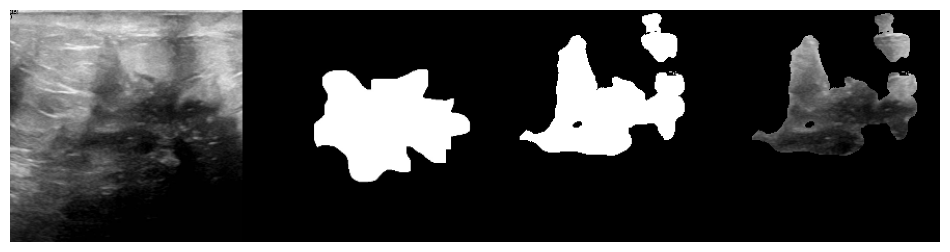

 Epoch: 37 of 100, Iter.: 16 of 16, Train Loss: 0.311292, IoU: 0.841219, Dice: 0.911303
 Epoch: 37 of 100, Iter.: 16 of 16, Valid Loss: 0.613234, IoU: 0.546627, Dice: 0.670268


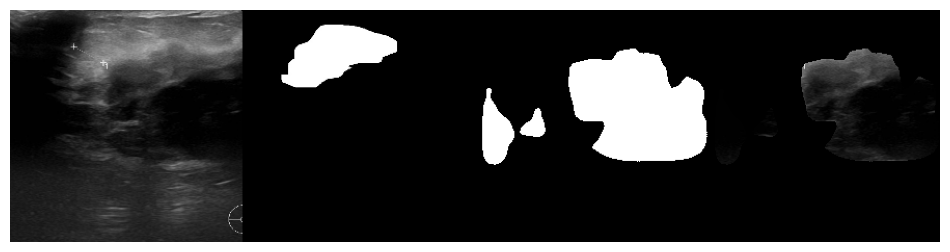

 Epoch: 38 of 100, Iter.: 16 of 16, Train Loss: 0.291069, IoU: 0.860807, Dice: 0.924191
 Epoch: 38 of 100, Iter.: 16 of 16, Valid Loss: 0.661655, IoU: 0.517380, Dice: 0.634082


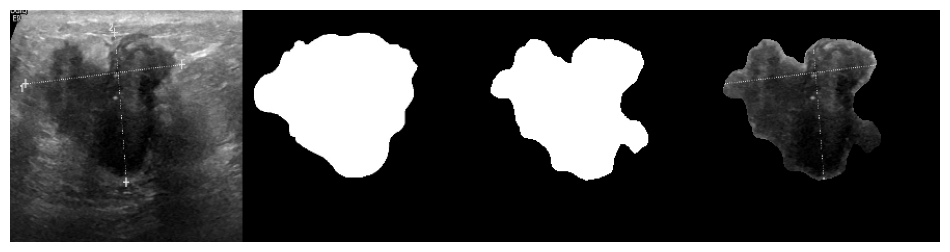

 Epoch: 39 of 100, Iter.: 16 of 16, Train Loss: 0.299250, IoU: 0.849306, Dice: 0.914287
 Epoch: 39 of 100, Iter.: 16 of 16, Valid Loss: 0.640850, IoU: 0.556650, Dice: 0.678304


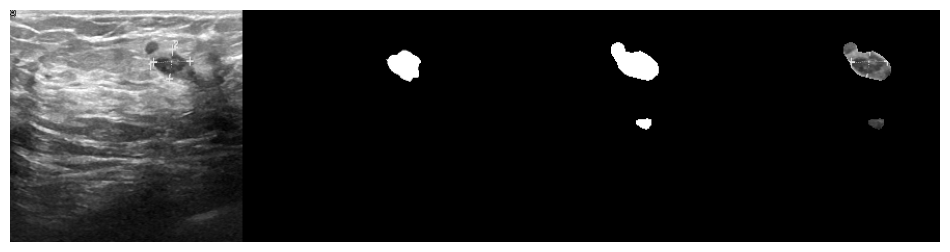

 Epoch: 40 of 100, Iter.: 16 of 16, Train Loss: 0.308752, IoU: 0.833795, Dice: 0.905976
 Epoch: 40 of 100, Iter.: 16 of 16, Valid Loss: 0.647035, IoU: 0.516703, Dice: 0.631327


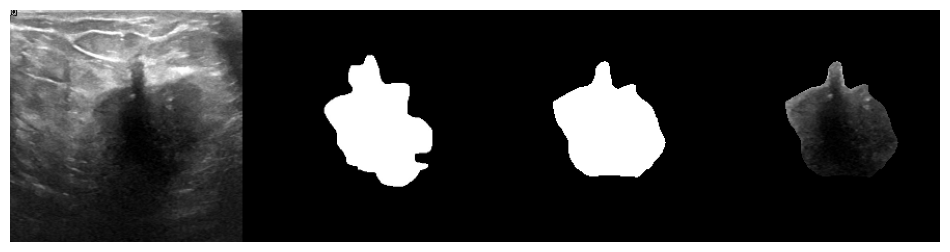

 Epoch: 41 of 100, Iter.: 16 of 16, Train Loss: 0.300169, IoU: 0.826365, Dice: 0.899518
 Epoch: 41 of 100, Iter.: 16 of 16, Valid Loss: 0.729753, IoU: 0.462168, Dice: 0.588775


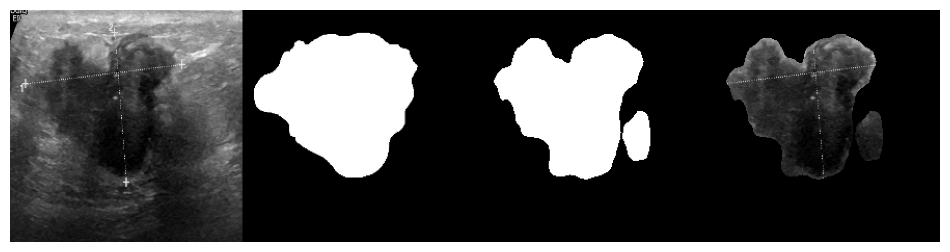

 Epoch: 42 of 100, Iter.: 16 of 16, Train Loss: 0.293307, IoU: 0.829312, Dice: 0.898615
 Epoch: 42 of 100, Iter.: 16 of 16, Valid Loss: 0.629671, IoU: 0.524009, Dice: 0.653878


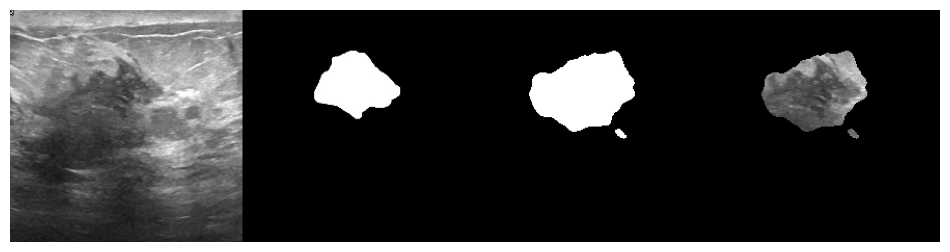

 Epoch: 43 of 100, Iter.: 16 of 16, Train Loss: 0.286524, IoU: 0.839777, Dice: 0.910195
 Epoch: 43 of 100, Iter.: 16 of 16, Valid Loss: 0.698761, IoU: 0.484490, Dice: 0.608977


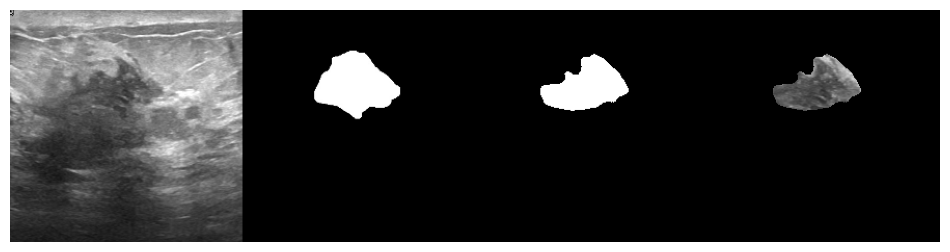


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 2min 14s, sys: 2min 47s, total: 5min 2s
Wall time: 1min 49s


In [25]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:22, Best_IOU:0.5830, Best_DiceScore:0.6945


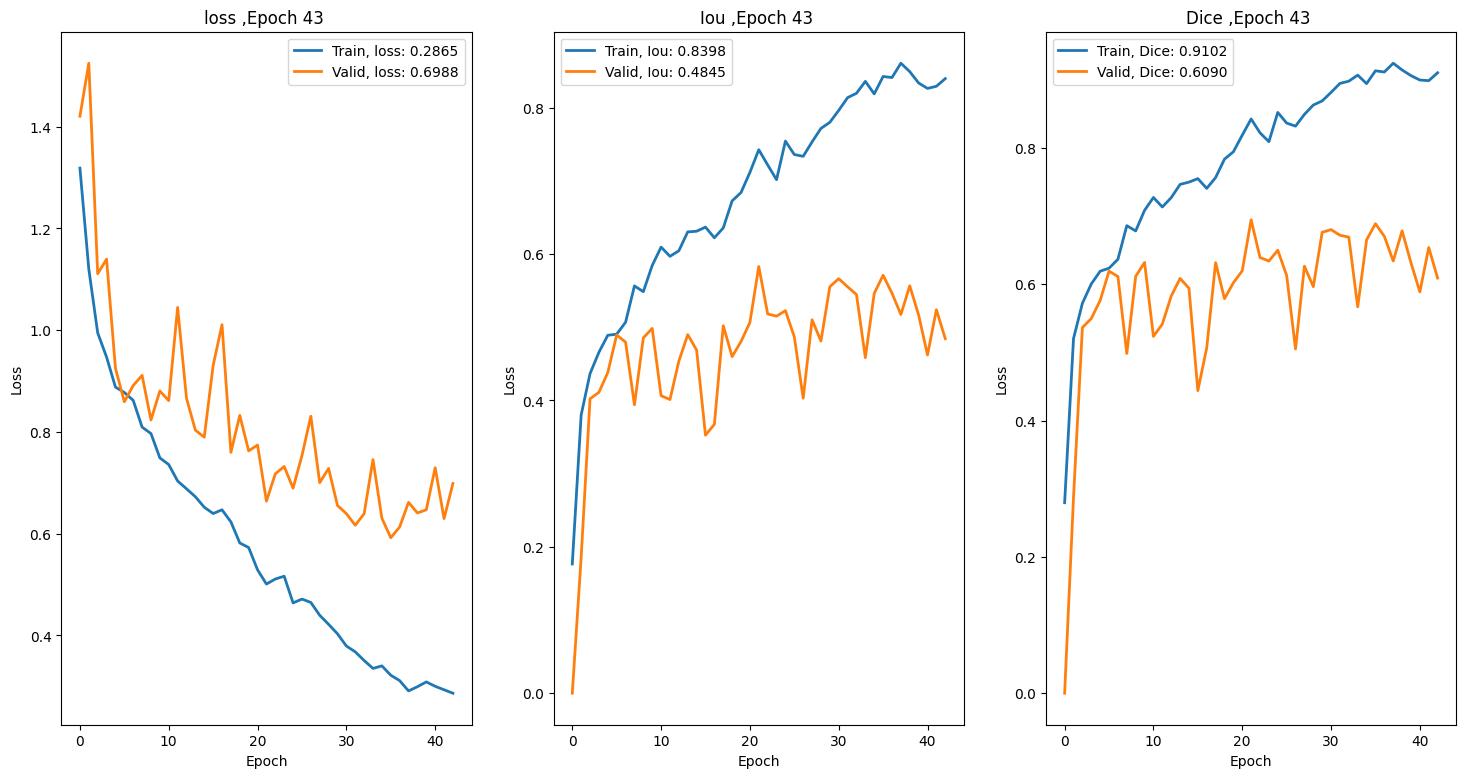

In [26]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()